# Standard Restricted Boltzmann Machine
Created on Mon May 23th 2016 <br>
Boltzmann machine consists of visible units (components of observations) and hidden units (models depdencies between components of observations). 
The **standard RBM** has binary hidden and visible units ($\in \{0, 1\}$, under a Bernouilli distribution. The goal of training an RBM is to learn the visible-hidden weights and neuron activation biases such that the RBM learns to reconstruct the input data. 

## Positive phase
1. the states of the visible layer is set to be a training example $\textbf{x}$ (vector)
2. $\textbf{x}$ is propagated to the hidden layer using weights matrix $W$, which is associated with the connection between the visible units and the hidden units. The resulting hidden layer activations is $\textbf{h}$.

## Negative phase (Reconstruction)
1. Propagate back $\textbf{h}$ to the visible layer using $\textbf{W}^{\intercal}$ (since the connections between hidden/visible layer are undirected). The activation of the reconstructed trainign example is $\tilde{\textbf{x}}$.
2. Propagate the reconstructed $\tilde{\textbf{x}}$ to the hidden layer: $\tilde{\textbf{h}}$ 

## Optimization objective
The optimization objective of an RBM is to minimize the error $Err = (\textbf{x} - \tilde{\textbf{x}})^2$. The weights are then updated using:

\begin{align}
\textbf{W} := \textbf{W} + \alpha (\textbf{x} \ \textbf{h}^{\intercal} - \tilde{\textbf{x}}\  \tilde{\textbf{h}}^{\intercal}) 
\end{align}

where $\alpha$ is the learning rate.
1. The equation above uses one iteration of the **Contrastive Divergence (CD)** algorithm to determine the gradient, i.e one iteration of Positive Phase/Negative Phase step. This can be generalized using $k$ steps of Contrastive Divergence (CD-$k$):<br><br>
\begin{align}
\textbf{W} := \textbf{W} + \alpha \left((\textbf{x} \ \textbf{h}^{\intercal})_0 - (\tilde{\textbf{x}}\  \tilde{\textbf{h}}^{\intercal})_k \right)
\end{align}
2. For $m$ training examples, the gradient $(\textbf{x} \ \textbf{h}^{\intercal} - \tilde{\textbf{x}}\  \tilde{\textbf{h}}^{\intercal})$  must be normalized to the number of examples.

[A Practical Guide to Training Restricted Boltzmann Machines](https://www.cs.toronto.edu/~hinton/absps/guideTR.pdf "A Practical Guide to Training Restricted Boltzmann Machines")


In [51]:
%matplotlib inline
#List of modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math as math

## List of functions:
<ul>
  <li>**`display(data, fig_nbr, margin, do_img_scale=False)`** &rarr; display in grey-scale any number of images</li>
  <ul>
      <li>**`data`**: a matrix where each row is an "unwinded" 28*28px image.</li>
      <li>**`fig_nbr`**: update **`fig_nbr`** value everytime **`display()`** is called, and avoid overwriting on an existing figure.</li>
      <li>**`margin`**: margin (in pixel) between each image</li>
      <li>**`do_img_scale`**: convert the pixel value to be in the range 0-255. If **`data`** value are normalized to 1, use **`do_img_scale=True`** (Default value=False)</li>
  </ul>


  <li>**`sigmoid(z)`**  &rarr; the function do the following transformation (element-wise)</li>
\begin{align}
\text{sigmoid}(z) = \frac{1}{1 + e^{-z}}
\end{align}

  <li>**`train(data, max_epoch, num_hid, learning_rate)`** &rarr; train weights using a single layer RBM
  <ul>
      <li>**`data`**: training_data</li>
      <li>**`max_epoch`**: number of iterations (note that this RBM runs only 1 iteration of contrastive divergence). </li>
      <li>**`num_hid`**: number of hidden units </li>
      <li>**`learning_rate`** </li>
  </ul>
  This function returns the following parameters: trained weight (**`weights`**),  least square error versus epoch number (**`hist_err`**), reconstructed image (**`neg_vis_probs`**) ,  state of the hidden units (**`neg_hid_probs`**)
</ul>

In [52]:
def sigmoid(z):
    return 1.0/(1 + np.exp(-z))


def display(data, fig_nbr, margin, do_img_scale=False):    
    num_of_imgs = np.shape(data)[0]
    if do_img_scale == True:
        data = (data * 255).astype(np.uint8)
    
    #create board and set dimensions to show images
    num_imgs_row = math.ceil( math.sqrt(num_of_imgs) ) #max Nbr of image in a row     
    num_imgs_col = math.ceil( 1.0 * num_of_imgs / num_imgs_row ) #max Nbr of image in a col
    board_height = num_imgs_col * img_width + 2*margin + (num_imgs_col - 1 ) * 2
    board_width = num_imgs_row * img_height + 2*margin + (num_imgs_row - 1 ) * 2 
    display_board = np.zeros((board_height, board_width))
    active_row_col = np.array([0, 0])
    
    for i in range(num_of_imgs):
        one_image = data[i,:].reshape((img_height, img_width))
        display_board[active_row_col[0] * (28 + margin) + margin : active_row_col[0] * \
                      (28 + margin) + img_height + margin , active_row_col[1] * (28 + margin) \
                      + margin : active_row_col[1] * (28 + margin) + img_width + margin] = one_image
        if ((i + 1) % num_imgs_row) == 0: #
            active_row_col[0] += 1
            active_row_col[1] = 0 
        else:
            active_row_col[1] += 1
    plt.figure(fig_nbr)        
    plt.axis('off')    
    plt.imshow(display_board, cmap='gray_r') #cmap=plt.cm.bwr (alternative blue/red color map)

    
def train(data, max_epoch, num_hid, learning_rate):
    #Parameters
    # num_examples = number of training examples
    # num_vis = number of visible units
    num_exples, num_vis = np.shape(data)
    #Initialize weight matrix using a Gaussian distribution with mean 0 and standard deviations
    # 0.1 to to break symmetry. 
    #Large random values can speed the initial learning but could lead to a slightly worse final model
    weights = 0.1 * np.random.randn(num_vis, num_hid)
    
    hid_bias =np.zeros((1, num_hid)) #vector bias for each hidden unit
    vis_bias = np.zeros((1, num_vis)) #vector bias for each viible unit
    
    hist_err = np.zeros( (max_epoch, 2) ) #history of Error (least square)
    pos_vis_probs = data #et the visible units = data
    
    for epoch in range(max_epoch): #main iteration to update the weights value
        #This is a CD1 (1 step of contrastive Divergence algorithm)
        #Positive phase (from visible to hidden state)
        pos_hid_activations = np.dot(pos_vis_probs, weights) + np.tile(hid_bias, [num_exples,1])
        #Probability of turning on a hidden unit
        #The hidden states must be binary, rather than using the probabilities themselves.
        #If the probabilities are used, each hidden unit can communicate a real-value to the
        # visible units during reconstruction. Thios seriously violates the information 
        #bottleneck created by the fact that a hidden unit can convey at most one bit (on average)
        #This information bottleneck acts as a strong regularizer
        pos_hid_probs = sigmoid(pos_hid_activations ) #size=(exples, hid)
        #size = (feat, examples) * (exples, hid) = (feat, hid)
        pos_prods = np.dot(np.transpose(pos_vis_probs), pos_hid_probs) 
        pos_hidact = np.reshape(np.sum(pos_hid_probs, axis=0),(1,num_hid)) #sum along rows (1, hid)
        pos_visact = np.reshape(np.sum(pos_vis_probs, axis=0), (1, num_vis))

        #For the first Gibbs sampling, hidden unit activation should be stochastic
        pos_hid_states = pos_hid_probs > np.random.rand(num_exples, num_hid) 
    
        #Start negative phase: reconstruiction phase of the visible unit
        neg_vis_activations = np.dot(pos_hid_states, np.transpose(weights))
        neg_vis_probs = sigmoid(neg_vis_activations + np.tile(vis_bias, [num_exples,1]))
        neg_hid_activations = np.dot(neg_vis_probs, weights)
        neg_hid_probs = sigmoid(neg_hid_activations + np.tile(hid_bias, [num_exples,1]))
        neg_prods = np.dot(np.transpose(neg_vis_probs), neg_hid_probs)
        #Generate hidden unit
        neg_hidact = np.reshape(np.sum(neg_hid_probs, axis=0),(1,num_hid))
        neg_visact = np.reshape(np.sum(neg_vis_probs, axis=0), (1, num_vis))

        #Update weights and bias
        weights = weights + learning_rate * ((pos_prods - neg_prods)/num_exples)
        vis_bias = vis_bias + learning_rate * ((pos_visact - neg_visact)/num_exples)
        hid_bias = hid_bias + learning_rate * ((pos_hidact - neg_hidact)/num_exples)
        error = np.sum((pos_vis_probs - neg_vis_probs)**2)
        hist_err[epoch]= [epoch, error]
        #Show epoch and Error for every 10 iterations
        if epoch%10 == 0:
            print('Epoch Nbr:', epoch,' | Error:', int(error))
    return [weights, hist_err, neg_vis_probs, neg_hid_probs]


In [53]:
"""
Process training data file
mnist data file (csv format) contains a set of imgs where each image is 28*28px, i.e a square matrix (28,28), 
flattens into a row vector of size (1,28*28). Each px has a value between 0 and 255
"""
#Alternative to pandas.read_csv() is np.genfromtxt() but turn out to be much slower
mnist_data = pd.read_csv('train.csv') 
images_noLabel = mnist_data.iloc[:,1:].values


#Parameters
num_hid = 200
max_epoch = 300
save_param = True

print('Snapshot of a vector row (single image):', images_noLabel[0][250:300])
#Normalize vector row by 255 so px value is a float between 0 and 1
training_example = images_noLabel/255.0
img_width, img_height = (28, 28)

Snapshot of a vector row (single image): [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  54
 209 253 253  88   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0  93 254 253 238 170  17]


Epoch Nbr: 0  | Error: 8987756
Epoch Nbr: 10  | Error: 1976407
Epoch Nbr: 20  | Error: 1645595
Epoch Nbr: 30  | Error: 1453836
Epoch Nbr: 40  | Error: 1331552
Epoch Nbr: 50  | Error: 1246778
Epoch Nbr: 60  | Error: 1182287
Epoch Nbr: 70  | Error: 1132204
Epoch Nbr: 80  | Error: 1090790
Epoch Nbr: 90  | Error: 1054805
Epoch Nbr: 100  | Error: 1024358
Epoch Nbr: 110  | Error: 997482
Epoch Nbr: 120  | Error: 973156
Epoch Nbr: 130  | Error: 951338
Epoch Nbr: 140  | Error: 931229
Epoch Nbr: 150  | Error: 913642
Epoch Nbr: 160  | Error: 896973
Epoch Nbr: 170  | Error: 881977
Epoch Nbr: 180  | Error: 867712
Epoch Nbr: 190  | Error: 854537
Epoch Nbr: 200  | Error: 842159
Epoch Nbr: 210  | Error: 830840
Epoch Nbr: 220  | Error: 820094
Epoch Nbr: 230  | Error: 810474
Epoch Nbr: 240  | Error: 801363
Epoch Nbr: 250  | Error: 791771
Epoch Nbr: 260  | Error: 784310
Epoch Nbr: 270  | Error: 775712
Epoch Nbr: 280  | Error: 768381
Epoch Nbr: 290  | Error: 760474


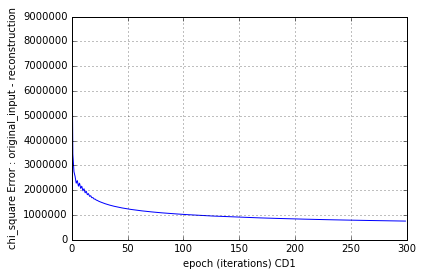

original images (25 first images of mnist file)
reconstructed images
features


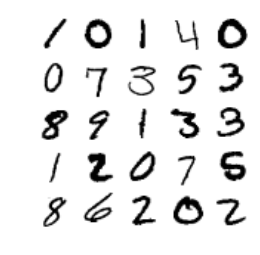

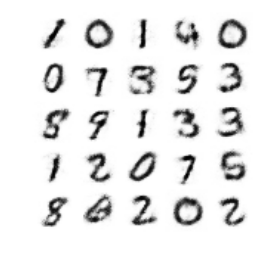

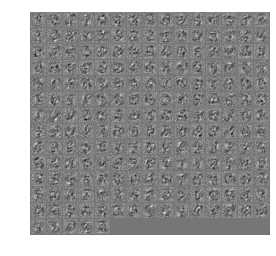

In [54]:
# Run the optimization

my_weights, hist_err, rec, hid = train(training_example, max_epoch=max_epoch, num_hid=num_hid, learning_rate = 0.1)


if save_param == True:
    np.savetxt("weights.csv", my_weights, delimiter=",")
    np.savetxt("hist_err.csv", hist_err, delimiter=",")

# Plot Error versus Iteration
plt.figure()
plt.plot(hist_err[:,0], hist_err[:,1])
plt.xlabel('epoch (iterations) CD1')
plt.ylabel('chi_square Error : original_input - reconstruction')
plt.grid(True)
plt.show()
print('original images (25 first images of mnist file)')
display(training_example[0:25,:], fig_nbr=1, margin=2, do_img_scale=False) # display the first 40 training examples 
print('reconstructed images')
display(rec[0:25,:], fig_nbr=2, margin=2, do_img_scale=False) # display the first 40 reconstructed examples
print('features')
display(np.transpose(my_weights)[0:num_hid,:], fig_nbr=3, margin=2, do_img_scale=False)